# 实验 v1.1（单文件）

## 思路

使用【可解释方法】对实验数据【预处理】消除歧视样本，并【重新训练】，目的是提升【模型的公平性】


## 实验简介

1. 选择数据集 --> Adult
2. 选择训练模型 --> XGboost
3. 选择可解释模型 --> Shap
4. 选择不公平的数据样本 --> 选择敏感属性的 |shap_values| 的较大值
5. 选择 k1 个最不公平的数据样本 --> k1=1000 约占训练集的 5%
6. 构造 k2 个预处理样本呢 --> 令 k2=k1
7. 选择预处理策略 --> 更改敏感属性标签并加入训练集中
8. 选择公平性指标 --> dp 和 eo

## 如何优化

1. 如何使用可解释的输出来选择不公平的数据样本
2. 选择多少个样本（百分比）
3. 构造样本时，是保持不变（`k1=k2`）还是膨胀（`k1<k2`）
4. 如何选择预处理策略，直接加入后，X_train 是否要重新缩放
5. 如何选择公平性指标

## 存在的问题

1. 感觉指标不充分
2. 


## 实验基本环境设置

In [79]:
# 导入依赖
import shap
import numpy as np
import pandas as pd


In [80]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

## 加载原始数据

In [81]:
# 加载数据
file = ('../input/adult.csv')
df = pd.read_csv(file, encoding='latin-1')

## 数据预处理部分

In [82]:
# 数据预处理
df[df == '?'] = np.nan
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)
X = df.drop(['income'], axis=1)
y = df['income']
y = y.map({"<=50K":0, ">50K":1})
# y

In [83]:
# 函数：数据拆分
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def split_df(X, y):
    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )

    # 将标签数字化
    categorical = [
        "workclass",
        "education",
        "marital.status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native.country",
    ]
    for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

    # 数据缩放
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    return X_train, X_test, y_train, y_test

In [84]:
# 数据拆分
X_train, X_test, y_train, y_test = split_df(X, y)

In [85]:
# 设置敏感属性
X_test["sex"].value_counts()
sex = X_test['sex']
sex = sex.map(lambda x : "男" if x > 0 else "女")

In [86]:
# 获得敏感属性的索引
feature_index = X.columns.get_loc("sex")
feature_index

9

## 指标预设

In [129]:
# 普通指标和公平性指标
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    r2_score,
    roc_curve,
    roc_auc_score,
)


from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
    mean_prediction,
)


from fairlearn.metrics import (
    false_positive_rate,
    false_negative_rate,
    count,
    selection_rate,
    MetricFrame,
)


def test_metrics(y_true, y_pred, sensitive_features):
    normal_metrics = {
        "样本数      ": count,
        "准确率      ": accuracy_score,  # 越大越好
        "精确率      ": precision_score,  # 越大越好
        "召回率      ": recall_score,
        "FPR        ": false_positive_rate,  # 越小越好
        "FNR        ": false_negative_rate,  # 越小越好
        "F1 Score   ": f1_score,  # f1 分数，越接近 1 越好
        "ROCAUC的面积": roc_auc_score # 1 表示最佳性能 0.5 表示随机分类器
        # "选择率      ": selection_rate,
        # "公平性平均预测": mean_prediction,  # 衡量不同群体之间的平均预测值是否相等
    }

    fairness_metrics = {
        "人口平等 差异": demographic_parity_difference,  # 越小越好
        "人口平等 比率": demographic_parity_ratio,  # 越接近 1 越好
        "机会均等 差异": equalized_odds_difference,  # 越小越好
        "机会均等 比率": equalized_odds_ratio,  # 越接近 1 越好
    }

    metric_frame = MetricFrame(
        metrics=normal_metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features,
    )

    # 画图
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],

        title="普通指标",
    )

    print(metric_frame.overall)

    params = {
        "y_true": y_true,
        "y_pred": y_pred,
        "sensitive_features": sensitive_features,
    }

    for k, v in fairness_metrics.items():
        print(k, v(**params))

In [134]:
def map_prob_2_label(y):
    return np.where(y > 0.5, 1, 0)

In [136]:
def test_model(model, X_test, y_test, sensitive, f=None, desc="默认测试"):
    y_pred = model(X_test)
    print(desc)
    if f is not None:
        y_pred = f(y_pred)
    test_metrics(y_test, y_pred, sensitive)

## 模型：逻辑回归

In [88]:
# 逻辑回归 - 训练
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [89]:
# 逻辑回归 - 预测
y_pred = logreg.predict(X_test)

In [90]:
# 逻辑回归 - 指标
test_metrics(y_test, y_pred, sex)

样本数            9769.000000
准确率               0.821681
精确率               0.710868
召回率               0.440865
FPR               0.057085
FNR               0.559135
F1 Score          0.544218
ROCAUC的面积         0.691890
dtype: float64
人口平等 差异 0.17305965639298973
人口平等 比率 0.16808117698325414
机会均等 差异 0.2678519815463287
机会均等 比率 0.15100051877108894


## 模型：XGBoost

In [106]:
# XGboost - 训练
import xgboost
xgboost_model = xgboost.XGBRegressor().fit(X_train, y_train)

In [107]:
# XGboost - 预测
y_pred_xgboost_1 = xgboost_model.predict(X_test)
y_pred_xgboost_1 = np.where(y_pred_xgboost_1 > 0.5, 1, 0)

In [108]:
# XGboost - 指标
test_metrics(y_test, y_pred_xgboost_1, sex)

样本数            9769.000000
准确率               0.862422
精确率               0.768377
召回率               0.615939
FPR               0.059109
FNR               0.384061
F1 Score          0.683765
ROCAUC的面积         0.778415
dtype: float64
人口平等 差异 0.16989595884523423
人口平等 比率 0.32250719180485066
机会均等 差异 0.08764799066199769
机会均等 比率 0.29597011190360795


## 使用可解释工具进行分析

In [94]:
# 计算 shap_values
explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X_train)

In [95]:
# 获得 k 个最大的索引
arr = shap_values[:, feature_index].values # numpy.ndarray
sorted_indices = np.argsort(np.abs(arr))
k = 1000
top_k_indices = sorted_indices[-k:]
# top_k_indices

In [96]:
# 获得 X_ext 拓展
X_ext = X_train.iloc[top_k_indices, :]
y_ext = y_train.iloc[top_k_indices]

In [97]:
# 统计缩放后的个数
tmp = X_train["sex"].unique()
tmp
X_train["sex"].value_counts()

sex
 0.699071    15310
-1.430470     7482
Name: count, dtype: int64

In [98]:
# 敏感属性 反转
X_ext.loc[:, "sex"] = np.where(X_ext.loc[:, "sex"] < 0, tmp[1], tmp[0])
# X_ext.head()

In [99]:
# 索引连接
# print(X_train.shape, X_test.shape)
X_train_2 = pd.concat([X_train, X_ext])
y_train_2 = pd.concat([y_train, y_ext])

## 模型：XGBoost + 处理过的训练集

In [100]:
# XGboost_2 - 训练
import xgboost
xgboost_model_2 = xgboost.XGBRegressor().fit(X_train_2, y_train_2)

In [101]:
# XGboost_2 - 预测
y_pred_xgboost_2 = xgboost_model_2.predict(X_test)
y_pred_xgboost_2 = np.where(y_pred_xgboost_2 > 0.5, 1, 0)

In [102]:
# # XGboost_2 - 指标
test_metrics(y_test, y_pred_xgboost_2, sex)

样本数            9769.000000
准确率               0.864162
精确率               0.770724
召回率               0.622721
FPR               0.058974
FNR               0.377279
F1 Score          0.688863
ROCAUC的面积         0.781874
dtype: float64
人口平等 差异 0.17175240889009005
人口平等 比率 0.3209544785797538
机会均等 差异 0.08581790895447716
机会均等 比率 0.286851314441789


## 模型：XGBoost 对照组

In [122]:
print(k)
random_k_index = np.random.randint(0, len(X_train), k)
X_ext_random = X_train.iloc[random_k_index, :]
y_ext_random = y_train.iloc[random_k_index]


1000


In [123]:
# 索引连接
X_train_3 = pd.concat([X_train, X_ext_random])
y_train_3 = pd.concat([y_train, y_ext_random])

In [124]:
# XGboost_3 - 训练
xgboost_model_3 = xgboost.XGBRegressor().fit(X_train_3, y_train_3)

In [125]:
# XGboost_3 - 预测
y_pred_xgboost_3 = xgboost_model_3.predict(X_test)
y_pred_xgboost_3 = np.where(y_pred_xgboost_3 > 0.5, 1, 0)

In [126]:
# # XGboost_3 - 指标
test_metrics(y_test, y_pred_xgboost_3, sex)

样本数            9769.000000
准确率               0.863855
精确率               0.772078
召回率               0.618906
FPR               0.058165
FNR               0.381094
F1 Score          0.687059
ROCAUC的面积         0.780371
dtype: float64
人口平等 差异 0.173104512234947
人口平等 比率 0.31267326024359277
机会均等 差异 0.09770579734311602
机会均等 比率 0.2766346922835883


第一次测试
样本数            9769.000000
准确率               0.862422
精确率               0.768377
召回率               0.615939
FPR               0.059109
FNR               0.384061
F1 Score          0.683765
ROCAUC的面积         0.778415
dtype: float64
人口平等 差异 0.16989595884523423
人口平等 比率 0.32250719180485066
机会均等 差异 0.08764799066199769
机会均等 比率 0.29597011190360795


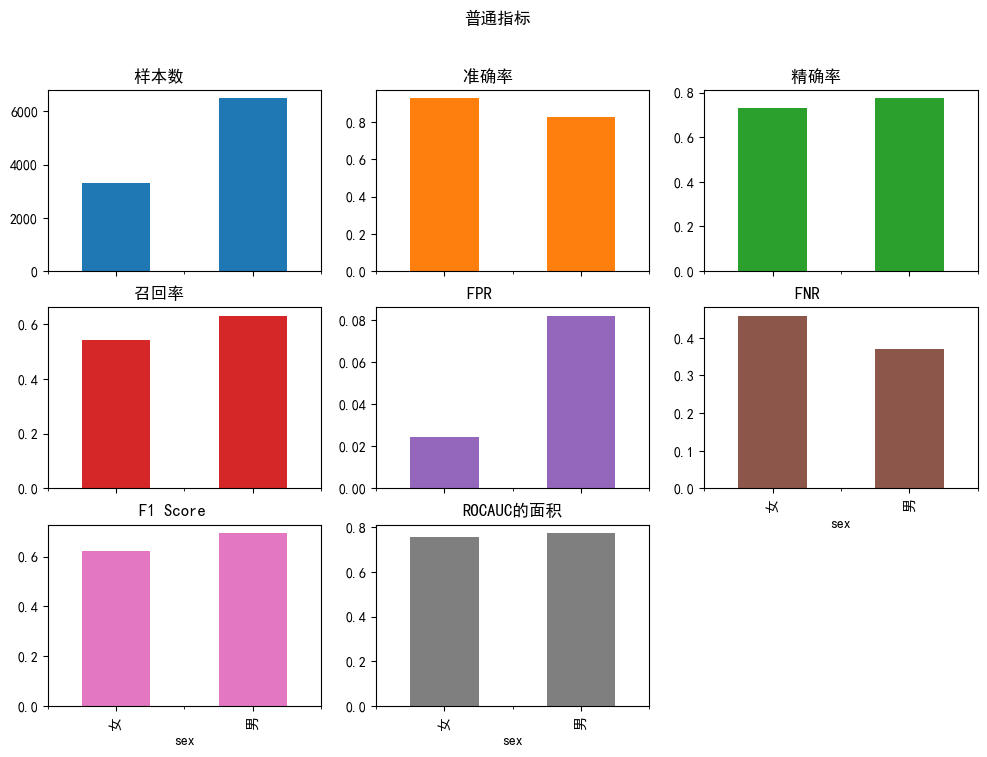

In [138]:
test_model(xgboost_model.predict, X_test, y_test, sex, map_prob_2_label, desc="第一次测试")

In [ ]:
test_model(xgboost_model_2, X_test, y_test, sex, map_prob_2_label, "SHAP 优化过的")

## 附录

### 选择率 和 公平性平均预测的含义

In [104]:
from fairlearn.metrics import selection_rate

# 选择率就是 【预测正例】 在 【预测总数】 中的比例
y_true = np.array([1, 0, 1])
y_pred = np.array([1, 1, 1])
print(selection_rate(y_true, y_pred))

1.0


In [105]:
from fairlearn.metrics import mean_prediction
# 和选择率一样
y_true = np.array([1, 0, 1])
y_pred = np.array([0, 0, 0])
print(mean_prediction(y_true, y_pred))

0.0
